In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import kde_funcs as kde

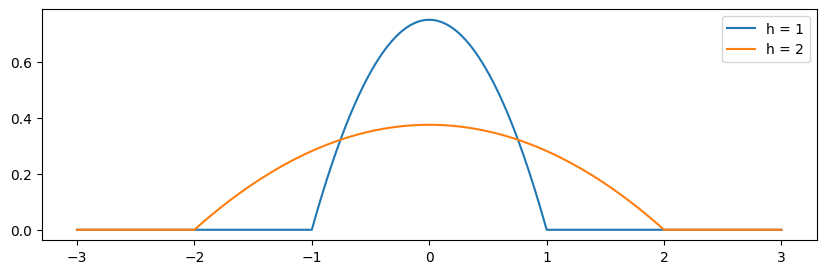

In [2]:
h = 2
x_arr = np.linspace(-3, 3, 1000)

plt.figure(figsize=(10, 3))
plt.plot(x_arr, kde.kernel_epa(x_arr), label='h = 1')
plt.plot(x_arr, (1/h) * kde.kernel_epa(x_arr / h), label=f'h = {h}')

plt.legend()
plt.show()

In [3]:
""" 
VL - Nichtparametrische Stat 

Def 4.2 Nadaraya-Watson-Schätzer

f_{n, h}^{NW} (x) = \frac {\sum Y_i K(x-x_i)}{\sum K(x-x_i)}} 

"""

' \nVL - Nichtparametrische Stat \n\nDef 4.2 Nadaraya-Watson-Schätzer\n\nf_{n, h}^{NW} (x) = \x0crac {\\sum Y_i K(x-x_i)}{\\sum K(x-x_i)}} \n\n'

In [4]:
def nadaraya_watson(x_obs, y_obs, x_pred, kernel, h=1):

    """
    Nadaraya-Watson kernel regression estimator
    """

    y_pred = np.zeros(x_pred.shape[0])

    if kernel == 'epa':
        kernel_func = kde.kernel_epa
    if kernel == 'gauss':
        kernel_func = kde.kernel_gauss
    if kernel == 'rect':
        kernel_func = kde.kernel_rect
    if kernel == 'tri':
        kernel_func = kde.kernel_tri
    if kernel == 'sinc':
        kernel_func = kde.kernel_sinc

    # for each evaluation point

        # w = evaluate kernel function of each observation at evaluation point
        # w * y = multiply with respective y_obs
        # y_pred = w * y / sum(w)

    for i, x in enumerate(x_pred):
        
        w = kernel_func((x - x_obs) / h)
        w = w / np.sum(w)
        
        y_pred[i] = np.sum(w * y_obs) 
        
        if np.abs(y_pred[i]) > 100:
            print('- '*10)
            print(f"y_pred = {y_pred[i]}")
            print(f"sum w = {np.sum(w)}")
            print(f"w = {np.round(w)}")
            print(f"y = {np.round(y_obs)}")

        # if np.sum(w) == 0: print(f"sum of weights = 0 at x = {x}")

    return y_pred

- - - - - - - - - - 
y_pred = -113.72415840649623
sum w = 0.9999999999999991
w = [  5.   3. -19.  23.  -8.  -4.   3.   3.  -1.  -2.]
y = [22. 18.  9. -2. -1.  5. -5.  6. 19. 22.]
- - - - - - - - - - 
y_pred = -102.06189568911796
sum w = 1.000000000000003
w = [  1.  -3.  -4.  14. -10.   2.   3.  -0.  -2.  -0.]
y = [22. 18.  9. -2. -1.  5. -5.  6. 19. 22.]
- - - - - - - - - - 
y_pred = -124.77902654075741
sum w = 0.9999999999999973
w = [  3.   3.  -5. -10.  28. -23.   3.   6.  -0.  -4.]
y = [22. 18.  9. -2. -1.  5. -5.  6. 19. 22.]
- - - - - - - - - - 
y_pred = 286.6804943953124
sum w = 0.9999999999999969
w = [ -4.  -0.   6.   3. -23.  28. -10.  -5.   3.   3.]
y = [22. 18.  9. -2. -1.  5. -5.  6. 19. 22.]
- - - - - - - - - - 
y_pred = -215.0895724771989
sum w = 0.9999999999999998
w = [  1.  -2.  -2.   2.   5. -11.  12.  -1.  -3.  -0.]
y = [22. 18.  9. -2. -1.  5. -5.  6. 19. 22.]
- - - - - - - - - - 
y_pred = 138.84368439405677
sum w = 0.9999999999999993
w = [-0.  1.  1. -2. -3.  8. -7. 

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\Kernel Simulations\kde_funcs.py:32: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, (1/np.pi), np.sin(x)/(np.pi*x))


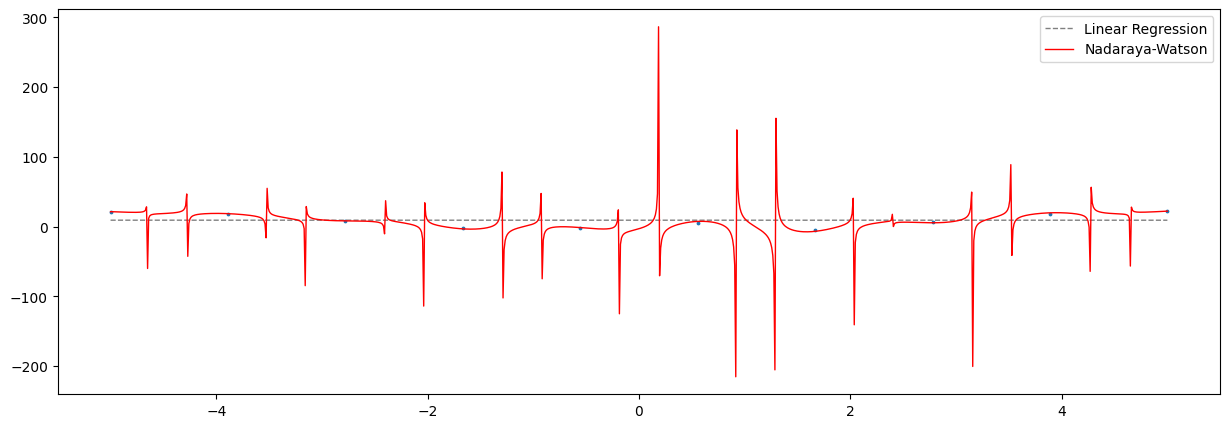

In [15]:
# simulation params
n = 10
x_min = -5
x_max = 5

np.random.seed(123)
# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n*100)
# print(f"making NW pred at {x_pred}")

h = 0.1 * (1/np.pi)
h = 0.1
y_pred_nw = nadaraya_watson(x, y, x_pred, 'sinc', h=h)

# Plot the original data and the regression line
plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=3)
plt.plot(x, y_pred, color='grey', ls='--', lw=1, label='Linear Regression')
plt.plot(x_pred, y_pred_nw, color='red', lw=1, label='Nadaraya-Watson')

plt.legend()
plt.show()

In [6]:
# PROBLEM with kernels that have negative values in naive NW estimator

# in the worst case scenario at some evaluation point x
# the kernel outputs cancel each other out in sum(K) and the sum gets really small ( in some cases even negative )
# therefore the effective weight w_i = K / sum(K) gets blown up

# even though the sum of the weights is still 1, the individual weights can get jumpy, eg :
# w = [ 35. -44.   2.  12.   1.  -6.  -2.   4.   2.  -3. ]
# y = [ 24. 10. 11. 10.  9. -0.  5.  5. 17. 26. ]

# therefore y_pred = sum( w_i * y_i ) gets blown up as well in both positive and negative directions

C:\Users\ytl_c\AppData\Local\Temp\ipykernel_9760\1094598137.py:29: RuntimeWarning: invalid value encountered in divide
  w = w / np.sum(w)


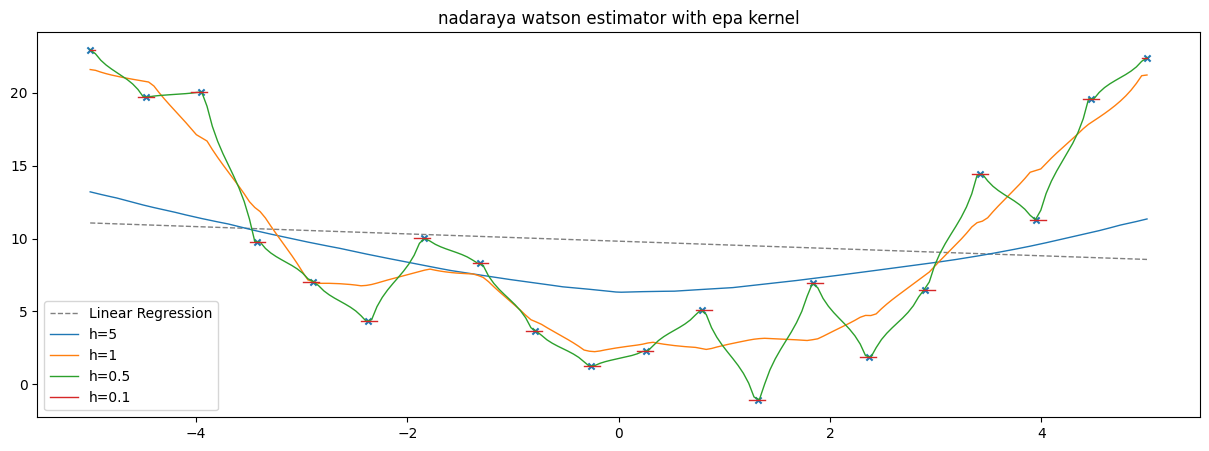

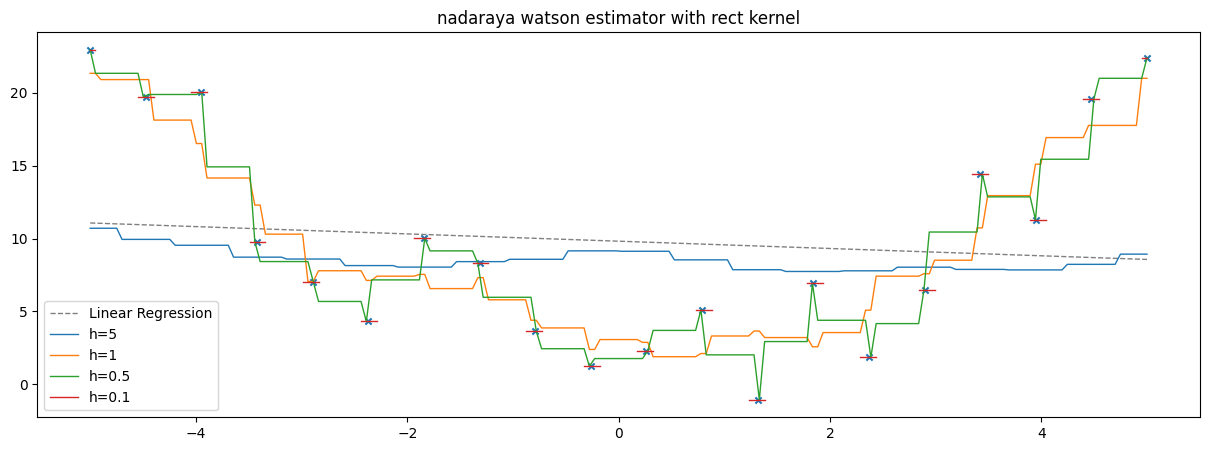

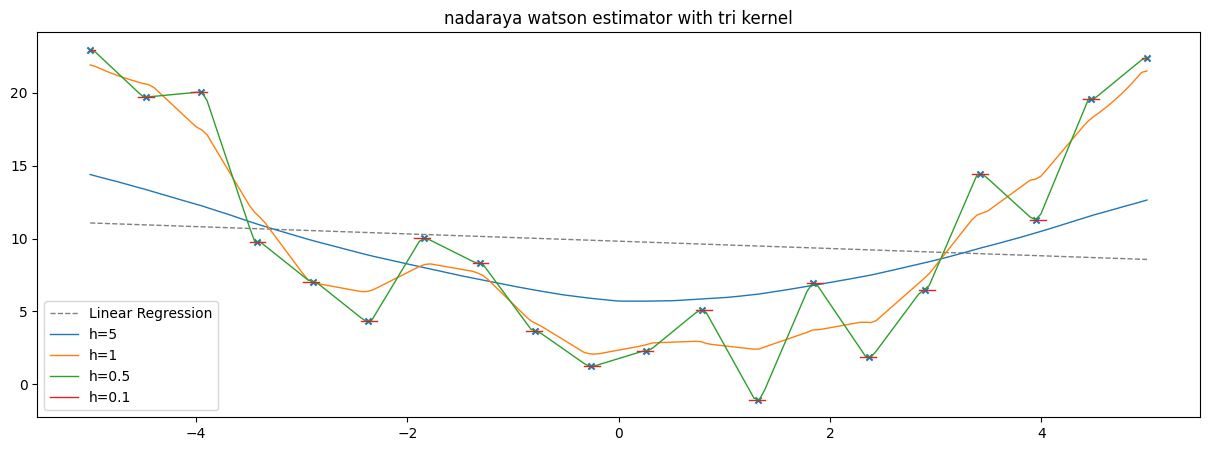

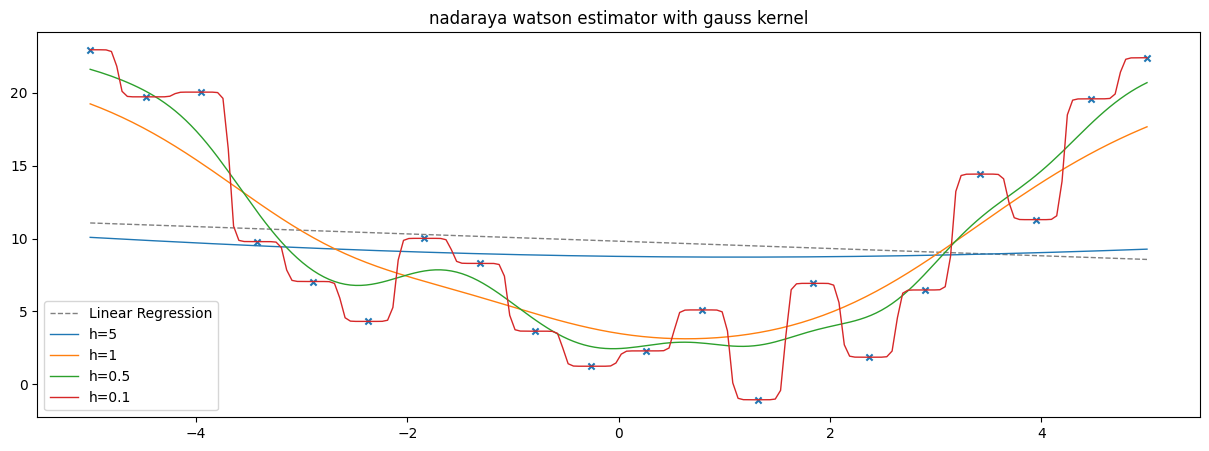

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\Kernel Simulations\kde_funcs.py:32: RuntimeWarning: invalid value encountered in divide
  return np.where(x == 0, (1/np.pi), np.sin(x)/(np.pi*x))


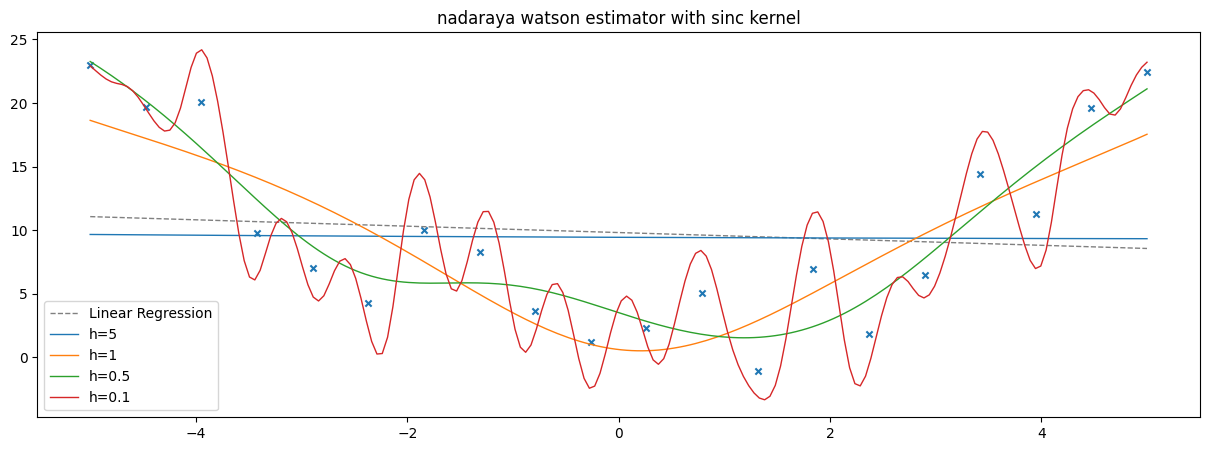

In [7]:
# simulation params
n = 20
x_min = -5
x_max = 5

# generate data using trend = x^2 and gaussian noise
x = np.linspace(x_min, x_max, n)
# print(f"observations at x = {x}")
y = x**2 + np.random.normal(0, 3, n)

# Fit Linear Regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Use Nadaraya-Watson Estimator
x_pred = np.linspace(x_min, x_max, n*10)
# print(f"making NW pred at {x_pred}")

kernel_types = ['epa', 'rect', 'tri', 'gauss', 'sinc']
h_harr = [5, 1, 0.5, 0.1]

for kernel_type in kernel_types :

    plt.figure(figsize=(15, 5))
    plt.scatter(x, y, s=20, marker='x')
    plt.plot(x, y_pred, color='grey', ls='--', lw=1, label='Linear Regression')

    for h in h_harr :

        y_pred_nw = nadaraya_watson(x, y, x_pred, kernel_type, h=h)
        plt.plot(x_pred, y_pred_nw, lw=1, label=f'h={h}')

    plt.title(f"nadaraya watson estimator with {kernel_type} kernel")
    plt.legend()
    plt.show()